# **Social Media Sentiment Analysis for Tunisian Arabizi**

## **Libraries**

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [2]:
#Basic Libraries
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#NLTK libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#Feature extraction process
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Models
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


#Dimensionality reduction library
from sklearn.decomposition import PCA 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Dataset**

In [4]:
train = pd.read_csv('NLP/Train.csv')
test = pd.read_csv('NLP/Test.csv')
SampleSubmission = pd.read_csv('NLP/SampleSubmission.csv')

## **Dataset Exploration**

In [5]:
print(f"The shape of the Train data is : {train.shape}")
print(f"The shape of the Test data is : {test.shape}")
print(f"The shape of the SampleSubmission data is : {SampleSubmission.shape}")

The shape of the Train data is : (70000, 3)
The shape of the Test data is : (30000, 2)
The shape of the SampleSubmission data is : (30000, 2)


In [6]:
train.head(3)

,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1


In [7]:
test.head(3)

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w barra rabbi m3ak 5ouya


In [8]:
SampleSubmission.head(3)

,ID,label
0,2DDHQW9,0
1,5HY6UEY,0
2,ATNVUJX,0


## **Exploratory Data Analysis**

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70000 non-null  object
 1   text    70000 non-null  object
 2   label   70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [10]:
train['label'].unique()

array([-1,  1,  0])

In [11]:
train['label'].value_counts()

 1    38239
-1    29295
 0     2466
Name: label, dtype: int64

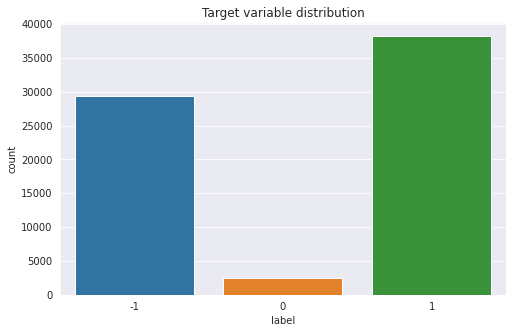

In [12]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["label"])
plt.title('Target variable distribution')
plt.show()

In [13]:
#Checking the dataset randomly
train['text'][np.random.randint(0, len(train))]

'ya biz9a rak 5rit fih'

In [14]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

## **Dataset Preprocessing**

In [15]:
punctuations = string.punctuation

### **Bag of words**

In [16]:
sentiments = [x for x in train['text'].values]

In [17]:
stemmer = PorterStemmer()

In [18]:
def sentence_clean(sentence):
  sentence_clean = re.sub(r'3sba+','3sba',sentence)
  sentence_clean = re.sub(r'ha*h*\w*j+','haj', sentence_clean) #haj
  sentence_clean = re.sub(r'hhh*', 'hh', sentence_clean) #hhh
  sentence_clean = re.sub(r'h+a[h|a]*', 'haa', sentence_clean) #hha haa hah
  sentence_clean = re.sub(r'he+h*[h|e]*', 'heh', sentence_clean) #heh
  sentence_clean = re.sub(r'bra+vo+', 'bravo', sentence_clean) #heh
  sentence_clean = re.sub(r'caa+', 'caa', sentence_clean) #heh
  sentence_clean = re.sub(r'cc*a+', 'ccaa', sentence_clean)
  sentence_clean = re.sub(r'cc{1,3}', 'cc', sentence_clean)
  sentence_clean = re.sub(r'cpr+', 'cpr', sentence_clean)
  sentence_clean = re.sub(r'ctt*', 'ct', sentence_clean)
  sentence_clean = re.sub(r'kkkk*', 'kkk', sentence_clean)
  sentence_clean = re.sub(r'\d+', '', sentence_clean)#Removing all digits in the sentences
  sentence_clean = re.sub(r'\s\w{1}\s',' ', sentence_clean)#Removing 1 word sentences
  return sentence_clean
  
def Bag_of_words(sentiment_list):
  Bag_of_Words = []
  for sentiment in sentiment_list:
    sentiment = sentence_clean(sentiment)
    words = nltk.word_tokenize(sentiment)
    for word in words:
      Bag_of_Words.append(stemmer.stem(word))#Stemming the words before appending
  return Bag_of_Words

In [19]:
BagofWords = Bag_of_words(sentiments)

BOW_series = pd.Series(BagofWords).value_counts()#Words value counts

rm_words = BOW_series[BOW_series.values == 1].index#Words that appear just once. To be removed

BagofWords = [w for w in BagofWords if w not in rm_words]

In [20]:
print(f"The Bag of word has a total of {len(BagofWords)} words with {len(set(BagofWords))} unique words")

The Bag of word has a total of 563166 words with 37271 unique words


In [21]:
#Selecting the unique words from the bag of words
BagofWords = list(set(BagofWords))
#Removing stopwords
BagofWords = [x for x in BagofWords if x not in punctuations]

### **Sentiments based BOW**

In [22]:
negative_sentiment = [sentiments for sentiments in train['text'][train['label'].eq(-1)]]
positive_sentiment = [sentiments for sentiments in train['text'][train['label'].eq(1)]]
neutral_sentiment = [sentiments for sentiments in train['text'][train['label'].eq(0)]]

negative_BOW = Bag_of_words(negative_sentiment)
positive_BOW = Bag_of_words(positive_sentiment)
neutral_BOW = Bag_of_words(neutral_sentiment)

In [23]:
len(negative_BOW), len(positive_BOW), len(neutral_BOW), len(BagofWords)

(349407, 284827, 17271, 37267)

In [24]:
##[words for words in BagofWords if words[0] == 'm']

### **Word Frequency Dictionary**

In [25]:
def word_freq_dict(BOW_overall, bow_sent):
  freq_dict = {}
  for word in BOW_overall:
    freq_dict[word] = 0
    for sent_word in bow_sent:
      if (word == sent_word):
        freq_dict[word] += 1
  return freq_dict

In [26]:
positive_wordfreq = word_freq_dict(BagofWords, positive_BOW)

In [27]:
negative_wordfreq = word_freq_dict(BagofWords, negative_BOW)
neutral_wordfreq = word_freq_dict(BagofWords, neutral_BOW)

In [28]:
len(BagofWords), len(positive_wordfreq), len(negative_wordfreq),len(neutral_wordfreq)

(37267, 37267, 37267, 37267)

In [29]:
def sentiment_weight(sent_wordfreq, sentiment):
  sentiment = sentence_clean(sentiment)
  words = nltk.word_tokenize(sentiment)
  words_clean = [stemmer.stem(word) for word in words]
  weight = 0
  for clean_word in words_clean:
    weight += sent_wordfreq.get(clean_word, 0)
  
  return weight

### **Implementing the weights**

In [30]:
train['Positive_weight'] = train['text'].apply(lambda x: sentiment_weight(positive_wordfreq, x))
train['Negative_weight'] = train['text'].apply(lambda x: sentiment_weight(negative_wordfreq, x))
train['Neutral_weight'] = train['text'].apply(lambda x: sentiment_weight(neutral_wordfreq, x))

In [31]:
train.head()

,ID,text,label,Positive_weight,Negative_weight,Neutral_weight
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,7615,7277,433
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,1075,1314,69
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,37277,37887,1893
3,U0TTYY8,ak slouma,1,1963,329,30
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,3926,3972,162


### **Implementing PCA for easy visualization**

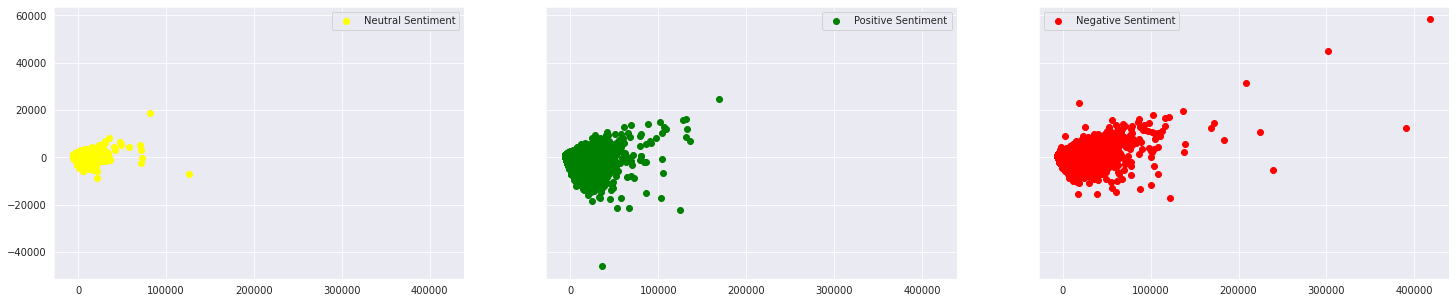

In [32]:
X = train[['Positive_weight','Negative_weight','Neutral_weight']]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns = ['feat1','feat2'])
X_pca['label'] = train['label']

fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize = (25,5),sharey = True, sharex = True)
axis[0].scatter(X_pca['feat1'][X_pca['label'].eq(0)],X_pca['feat2'][X_pca['label'].eq(0)],label = 'Neutral Sentiment', color = 'yellow')
axis[1].scatter(X_pca['feat1'][X_pca['label'].eq(1)],X_pca['feat2'][X_pca['label'].eq(1)], label = 'Positive Sentiment',color = 'green')
axis[2].scatter(X_pca['feat1'][X_pca['label'].eq(-1)],X_pca['feat2'][X_pca['label'].eq(-1)],label = 'Negative Sentiment',color = 'red')
axis[0].legend(); axis[1].legend(); axis[2].legend()

plt.show()

### **Transforming the test dataset**

In [33]:
test['Positive_weight'] = test['text'].apply(lambda x: sentiment_weight(positive_wordfreq, x))
test['Negative_weight'] = test['text'].apply(lambda x: sentiment_weight(negative_wordfreq, x))
test['Neutral_weight'] = test['text'].apply(lambda x: sentiment_weight(neutral_wordfreq, x))

In [34]:
test.head()

,ID,text,Positive_weight,Negative_weight,Neutral_weight
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik,2071,1972,65
1,5HY6UEY,ye gernabou ye 9a7ba,1117,1221,63
2,ATNVUJX,saber w barra rabbi m3ak 5ouya,4257,1250,34
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh,0,2,0
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...,6630,2134,90


### **Feature Engineering**

In [35]:
X = train[['Positive_weight','Negative_weight','Neutral_weight']]
y = train['label']
X_test = test[['Positive_weight','Negative_weight','Neutral_weight']]

#### **PolynomialFeatures**

In [36]:
poly_feat = PolynomialFeatures(interaction_only = True, degree = 2)
poly_feat.fit(X)
poly_train = poly_feat.transform(X)
poly_test = poly_feat.transform(X_test)

col = [f'PolyFeat_{n}' for n in range(poly_train.shape[1])]

poly_train = pd.DataFrame(poly_train, columns = col).drop('PolyFeat_0', axis = 1)
poly_test = pd.DataFrame(poly_test, columns = col).drop('PolyFeat_0', axis = 1)

for column in col[1:]:
  X[column] = poly_train[column]
  X_test[column] = poly_test[column]

#### **Feature Tweaking**

In [37]:
X['diff_1'] = (X['Positive_weight'] - X['Negative_weight']).abs()
X['diff_2'] = (X['Positive_weight'] - X['Neutral_weight']).abs()
X['diff_3'] = (X['Negative_weight'] - X['Neutral_weight']).abs()
X['SD'] = X[['Positive_weight','Negative_weight','Neutral_weight']].std(axis =1)
X['Mean'] = X[['Positive_weight','Negative_weight','Neutral_weight']].mean(axis =1)

#Test dataset
X_test['diff_1'] = (X_test['Positive_weight'] - X_test['Negative_weight']).abs()
X_test['diff_2'] = (X_test['Positive_weight'] - X_test['Neutral_weight']).abs()
X_test['diff_3'] = (X_test['Negative_weight'] - X_test['Neutral_weight']).abs()
X_test['SD'] = X_test[['Positive_weight','Negative_weight','Neutral_weight']].std(axis =1)
X_test['Mean'] = X_test[['Positive_weight','Negative_weight','Neutral_weight']].mean(axis =1)

#### **Rolling Mean, Min and Max**

In [38]:
##Rolling Mean
X['PW_rolling_mean_3'] = X['Positive_weight'].rolling(3).mean()
X['PW_rolling_mean_5'] = X['Positive_weight'].rolling(5).mean()
X['NG_rolling_mean_3'] = X['Negative_weight'].rolling(3).mean()
X['NG_rolling_mean_5'] = X['Negative_weight'].rolling(5).mean()
X['NU_rolling_mean_3'] = X['Neutral_weight'].rolling(3).mean()
X['NU_rolling_mean_5'] = X['Neutral_weight'].rolling(5).mean()

X_test['PW_rolling_mean_3'] = X_test['Positive_weight'].rolling(3).mean()
X_test['PW_rolling_mean_5'] = X_test['Positive_weight'].rolling(5).mean()
X_test['NG_rolling_mean_3'] = X_test['Negative_weight'].rolling(3).mean()
X_test['NG_rolling_mean_5'] = X_test['Negative_weight'].rolling(5).mean()
X_test['NU_rolling_mean_3'] = X_test['Neutral_weight'].rolling(3).mean()
X_test['NU_rolling_mean_5'] = X_test['Neutral_weight'].rolling(5).mean()

##Rolling Min
X['PW_rolling_min_3'] = X['Positive_weight'].rolling(3).min()
X['PW_rolling_min_5'] = X['Positive_weight'].rolling(5).min()
X['NG_rolling_min_3'] = X['Negative_weight'].rolling(3).min()
X['NG_rolling_min_5'] = X['Negative_weight'].rolling(5).min()
X['NU_rolling_min_3'] = X['Neutral_weight'].rolling(3).min()
X['NU_rolling_min_5'] = X['Neutral_weight'].rolling(5).min()

X_test['PW_rolling_min_3'] = X_test['Positive_weight'].rolling(3).min()
X_test['PW_rolling_min_5'] = X_test['Positive_weight'].rolling(5).min()
X_test['NG_rolling_min_3'] = X_test['Negative_weight'].rolling(3).min()
X_test['NG_rolling_min_5'] = X_test['Negative_weight'].rolling(5).min()
X_test['NU_rolling_min_3'] = X_test['Neutral_weight'].rolling(3).min()
X_test['NU_rolling_min_5'] = X_test['Neutral_weight'].rolling(5).min()

##Rolling Max
X['PW_rolling_max_3'] = X['Positive_weight'].rolling(3).max()
X['PW_rolling_max_5'] = X['Positive_weight'].rolling(5).max()
X['NG_rolling_max_3'] = X['Negative_weight'].rolling(3).max()
X['NG_rolling_max_5'] = X['Negative_weight'].rolling(5).max()
X['NU_rolling_max_3'] = X['Neutral_weight'].rolling(3).max()
X['NU_rolling_max_5'] = X['Neutral_weight'].rolling(5).max()

X_test['PW_rolling_max_3'] = X_test['Positive_weight'].rolling(3).max()
X_test['PW_rolling_max_5'] = X_test['Positive_weight'].rolling(5).max()
X_test['NG_rolling_max_3'] = X_test['Negative_weight'].rolling(3).max()
X_test['NG_rolling_max_5'] = X_test['Negative_weight'].rolling(5).max()
X_test['NU_rolling_max_3'] = X_test['Neutral_weight'].rolling(3).max()
X_test['NU_rolling_max_5'] = X_test['Neutral_weight'].rolling(5).max()

#Filling missing values with large value
X = X.fillna(-999999999)
X_test = X_test.fillna(-999999999)

### **CatBoosst Model**

In [43]:
split = StratifiedKFold(n_splits = 10, random_state = 2022, shuffle = True)

train_scores = []; test_scores = []
test_predictions = []
for (epoch, (train_index, valid_index)) in enumerate(split.split(X, y)):
  X_train = X.iloc[train_index]; y_train = y.iloc[train_index]
  X_valid = X.iloc[valid_index]; y_valid = y.iloc[valid_index]

  model = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.2,
                              bootstrap_type='Bernoulli',metric_period=100,max_depth = 8,
                     use_best_model=True)
  model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid, y_valid)], early_stopping_rounds=200,verbose=100,)
  pred = model.predict(X_valid)

  score_train = accuracy_score(y_train, model.predict(X_train))
  score_test = accuracy_score(y_valid, pred)
  train_scores.append(score_train); test_scores.append(score_test)

  test_df_pred = model.predict(X_test)
  test_predictions.append(test_df_pred)

  print(f"**********Epoch : {epoch + 1}*********")
  print(f"Train score : {score_train}")
  print(f"Test score : {score_test}\n")

print("**********Final Result*********")
print(f"Train score : {np.mean(train_scores)}")
print(f"Test score : {np.mean(test_scores)}")


0:	learn: 0.6030635	test: 0.6030635	test1: 0.6055714	best: 0.6055714 (0)	total: 137ms	remaining: 1m 49s
100:	learn: 0.7523333	test: 0.7523333	test1: 0.7368571	best: 0.7370000 (97)	total: 13.7s	remaining: 1m 35s
200:	learn: 0.7756349	test: 0.7756349	test1: 0.7378571	best: 0.7407143 (153)	total: 26.9s	remaining: 1m 20s
300:	learn: 0.7979048	test: 0.7979048	test1: 0.7338571	best: 0.7407143 (153)	total: 40.8s	remaining: 1m 7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7407142857
bestIteration = 153

Shrink model to first 154 iterations.
**********Epoch : 1*********
Train score : 0.7645079365079365
Test score : 0.7407142857142858



0:	learn: 0.6090952	test: 0.6090952	test1: 0.6130000	best: 0.6130000 (0)	total: 135ms	remaining: 1m 47s
100:	learn: 0.7543968	test: 0.7543968	test1: 0.7310000	best: 0.7310000 (100)	total: 13.4s	remaining: 1m 32s
200:	learn: 0.7772698	test: 0.7772698	test1: 0.7350000	best: 0.7387143 (158)	total: 26.6s	remaining: 1m 19s
300:	learn: 0.7992857	test: 0.7992857	test1: 0.7367143	best: 0.7388571 (292)	total: 39.9s	remaining: 1m 6s
400:	learn: 0.8191587	test: 0.8191587	test1: 0.7371429	best: 0.7404286 (370)	total: 53.1s	remaining: 52.9s
500:	learn: 0.8378254	test: 0.8378254	test1: 0.7342857	best: 0.7404286 (370)	total: 1m 6s	remaining: 39.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7404285714
bestIteration = 370

Shrink model to first 371 iterations.
**********Epoch : 2*********
Train score : 0.8138095238095238
Test score : 0.7404285714285714



0:	learn: 0.6023492	test: 0.6023492	test1: 0.6124286	best: 0.6124286 (0)	total: 137ms	remaining: 1m 49s
100:	learn: 0.7531746	test: 0.7531746	test1: 0.7401429	best: 0.7402857 (98)	total: 13.3s	remaining: 1m 31s
200:	learn: 0.7776508	test: 0.7776508	test1: 0.7385714	best: 0.7424286 (112)	total: 26.5s	remaining: 1m 19s
300:	learn: 0.7981270	test: 0.7981270	test1: 0.7344286	best: 0.7424286 (112)	total: 40s	remaining: 1m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7424285714
bestIteration = 112

Shrink model to first 113 iterations.
**********Epoch : 3*********
Train score : 0.7552539682539683
Test score : 0.7424285714285714



0:	learn: 0.6332698	test: 0.6332698	test1: 0.6267143	best: 0.6267143 (0)	total: 293ms	remaining: 3m 53s
100:	learn: 0.7523651	test: 0.7523651	test1: 0.7331429	best: 0.7341429 (92)	total: 29.4s	remaining: 3m 23s
200:	learn: 0.7758413	test: 0.7758413	test1: 0.7275714	best: 0.7341429 (92)	total: 45.2s	remaining: 2m 14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7341428571
bestIteration = 92

Shrink model to first 93 iterations.
**********Epoch : 4*********
Train score : 0.7504285714285714
Test score : 0.7341428571428571



0:	learn: 0.6058571	test: 0.6058571	test1: 0.5968571	best: 0.5968571 (0)	total: 139ms	remaining: 1m 51s
100:	learn: 0.7536032	test: 0.7536032	test1: 0.7317143	best: 0.7321429 (86)	total: 13.3s	remaining: 1m 32s
200:	learn: 0.7770794	test: 0.7770794	test1: 0.7338571	best: 0.7342857 (144)	total: 26.6s	remaining: 1m 19s
300:	learn: 0.7997302	test: 0.7997302	test1: 0.7298571	best: 0.7342857 (144)	total: 39.9s	remaining: 1m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7342857143
bestIteration = 144

Shrink model to first 145 iterations.
**********Epoch : 5*********
Train score : 0.7641587301587301
Test score : 0.7342857142857143



0:	learn: 0.6252540	test: 0.6252540	test1: 0.6281429	best: 0.6281429 (0)	total: 138ms	remaining: 1m 50s
100:	learn: 0.7543968	test: 0.7543968	test1: 0.7380000	best: 0.7380000 (100)	total: 16s	remaining: 1m 50s
200:	learn: 0.7765079	test: 0.7765079	test1: 0.7357143	best: 0.7395714 (104)	total: 29.3s	remaining: 1m 27s
300:	learn: 0.7976667	test: 0.7976667	test1: 0.7324286	best: 0.7395714 (104)	total: 42.6s	remaining: 1m 10s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7395714286
bestIteration = 104

Shrink model to first 105 iterations.
**********Epoch : 6*********
Train score : 0.7552539682539683
Test score : 0.7395714285714285



0:	learn: 0.6129365	test: 0.6129365	test1: 0.6104286	best: 0.6104286 (0)	total: 137ms	remaining: 1m 49s
100:	learn: 0.7517937	test: 0.7517937	test1: 0.7454286	best: 0.7464286 (81)	total: 13.3s	remaining: 1m 32s
200:	learn: 0.7782857	test: 0.7782857	test1: 0.7411429	best: 0.7464286 (81)	total: 27.8s	remaining: 1m 22s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7464285714
bestIteration = 81

Shrink model to first 82 iterations.
**********Epoch : 7*********
Train score : 0.7458888888888889
Test score : 0.7464285714285714



0:	learn: 0.6139524	test: 0.6139524	test1: 0.6102857	best: 0.6102857 (0)	total: 137ms	remaining: 1m 49s
100:	learn: 0.7524286	test: 0.7524286	test1: 0.7328571	best: 0.7334286 (78)	total: 13.3s	remaining: 1m 31s
200:	learn: 0.7764127	test: 0.7764127	test1: 0.7348571	best: 0.7362857 (166)	total: 26.5s	remaining: 1m 18s
300:	learn: 0.7968571	test: 0.7968571	test1: 0.7314286	best: 0.7362857 (166)	total: 39.7s	remaining: 1m 5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7362857143
bestIteration = 166

Shrink model to first 167 iterations.
**********Epoch : 8*********
Train score : 0.7685238095238095
Test score : 0.7362857142857143



0:	learn: 0.6080794	test: 0.6080794	test1: 0.6161429	best: 0.6161429 (0)	total: 136ms	remaining: 1m 48s
100:	learn: 0.7533651	test: 0.7533651	test1: 0.7352857	best: 0.7352857 (100)	total: 13.3s	remaining: 1m 31s
200:	learn: 0.7792222	test: 0.7792222	test1: 0.7358571	best: 0.7385714 (187)	total: 26.5s	remaining: 1m 18s
300:	learn: 0.8005079	test: 0.8005079	test1: 0.7327143	best: 0.7385714 (187)	total: 39.8s	remaining: 1m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7385714286
bestIteration = 187

Shrink model to first 188 iterations.
**********Epoch : 9*********
Train score : 0.7761904761904762
Test score : 0.7385714285714285



0:	learn: 0.6088889	test: 0.6088889	test1: 0.5967143	best: 0.5967143 (0)	total: 138ms	remaining: 1m 50s
100:	learn: 0.7538254	test: 0.7538254	test1: 0.7298571	best: 0.7322857 (82)	total: 13.3s	remaining: 1m 32s
200:	learn: 0.7770794	test: 0.7770794	test1: 0.7337143	best: 0.7345714 (192)	total: 26.6s	remaining: 1m 19s
300:	learn: 0.7987778	test: 0.7987778	test1: 0.7312857	best: 0.7345714 (192)	total: 39.9s	remaining: 1m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7345714286
bestIteration = 192

Shrink model to first 193 iterations.
**********Epoch : 10*********
Train score : 0.7752857142857142
Test score : 0.7345714285714285

**********Final Result*********
Train score : 0.7669301587301588
Test score : 0.7387428571428571


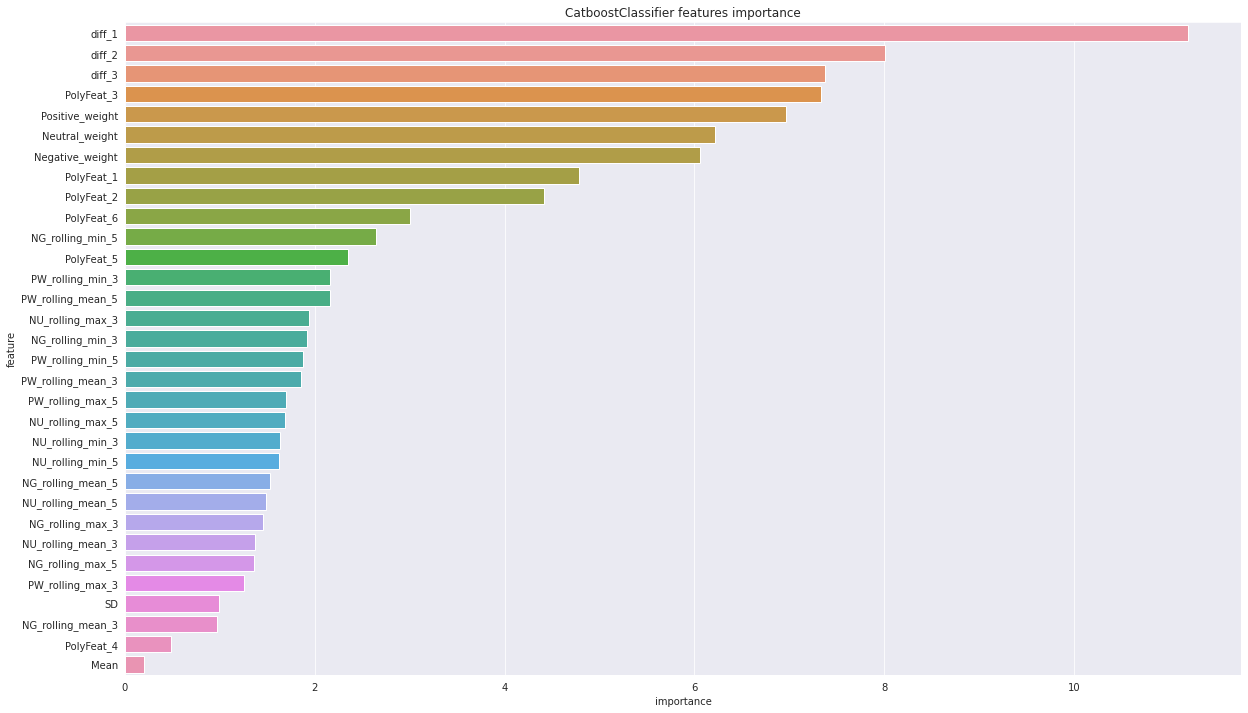

In [44]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False))
plt.title('CatboostClassifier features importance');

### **Model Prediction**

In [45]:
model = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.2,
                          bootstrap_type='Bernoulli',metric_period=100,max_depth = 8) #use_best_model=True)
model.fit(X, y)

pred = model.predict(X_test)

0:	learn: 0.6130143	total: 144ms	remaining: 1m 54s
100:	learn: 0.7511714	total: 14.1s	remaining: 1m 37s
200:	learn: 0.7739286	total: 28.1s	remaining: 1m 23s
300:	learn: 0.7936714	total: 42.2s	remaining: 1m 9s
400:	learn: 0.8111000	total: 56.2s	remaining: 55.9s
500:	learn: 0.8303429	total: 1m 10s	remaining: 41.9s
600:	learn: 0.8473143	total: 1m 24s	remaining: 27.9s
700:	learn: 0.8620143	total: 1m 38s	remaining: 13.9s
799:	learn: 0.8764286	total: 1m 52s	remaining: 0us


In [46]:
sub1 = SampleSubmission.copy()
sub1['label'] = pred
sub1['ID'] = test['ID']

sub1.to_csv('Catboost_model.csv', index = False)